In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import log_loss, accuracy_score
from sklearn.metrics import f1_score,precision_score, recall_score
from sklearn.metrics import precision_recall_curve, auc
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV

In [26]:
#importing the dataset
df = pd.read_csv('predictive_maintenance.csv')

# Define a mapping dictionary for encoding
type_map = {'L': 0, 'M': 1, 'H': 2}
# Encode the "Type" column using the mapping dictionary
df['Type'] = df['Type'].map(type_map)

# Display the DataFrame
print(df.head())
print(df.shape)

# Define the features and targets
X = df.iloc[:, 2:8].values  # FEATURES
y = df.iloc[:, 8].values  # BINARY TARGETS OF COLUMN 9

# Separate "not-failed" and "failed" samples
not_failed_indices = np.where(y == 0)[0]
failed_indices = np.where(y == 1)[0]

# Split the DataFrame into features and target variables
# falure dataset
X_failure = X[failed_indices]  # Features
y_failure = y[failed_indices] # Target variable

# no falure dataset
X_no_failure =  X[not_failed_indices]  # Features
y_no_failure = y[not_failed_indices]  # Target variable

# spliting the datasets into training and validation
# failure data set
X_train_failure, X_test_failure, y_train_failure, y_test_failure = train_test_split(
    X_failure, y_failure, test_size=0.1, random_state=0)

# no_failure dataset
X_train_no_failure, X_test_no_failure, y_train_no_failure, y_test_no_failure = train_test_split(
    X_no_failure, y_no_failure, test_size=0.1, random_state=0)


# merge the taining data set
X_train = np.concatenate([X_train_failure, X_train_no_failure], axis = 0)
y_train = np.concatenate([y_train_failure, y_train_no_failure], axis= 0)

# merging the test dataset
X_test = np.concatenate([X_test_failure, X_test_no_failure], axis = 0)
y_test = np.concatenate([y_test_failure, y_test_no_failure], axis = 0)

# implementing biased sampling method
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train) # balanced dataset

   UDI Product ID  Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860     1                298.1                    308.6   
1    2     L47181     0                298.2                    308.7   
2    3     L47182     0                298.1                    308.5   
3    4     L47183     0                298.2                    308.6   
4    5     L47184     0                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Target Failure Type  
0                    1551         42.8                0       0   No Failure  
1                    1408         46.3                3       0   No Failure  
2                    1498         49.4                5       0   No Failure  
3                    1433         39.5                7       0   No Failure  
4                    1408         40.0                9       0   No Failure  
(10000, 10)


In [4]:
# Using unbalanced training dataset
# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [0.1, 0.01, 0.001]
}

# Create SVM classifier
svm = SVC()

# Instantiate GridSearchCV
grid_search_unbalanced = GridSearchCV(estimator=svm, param_grid=param_grid, cv=9, scoring='accuracy')

# Unbalanced dataset
# Perform grid search on the training data
grid_search_unbalanced.fit(X_train, y_train)

# Print the best parameters found
print("Best Parameters for unballanced training data:", grid_search_unbalanced.best_params_)



Best Parameters for unballanced training data: {'C': 10, 'gamma': 0.001}


For Unbalanced training dataset:
rbf SVM - Training Accuracy: 0.98
Test Accuracy: 0.975024975024975
rbf SVM - Test Accuracy for failure only dataset: 0.35
rbf SVM - Test Accuracy for no failure only dataset: 1.00
rbf SVM - F1 Score: 0.4897959183673469
Precision: 0.8
Recall: 0.35294117647058826
AUC-PR: 0.5019946402323447


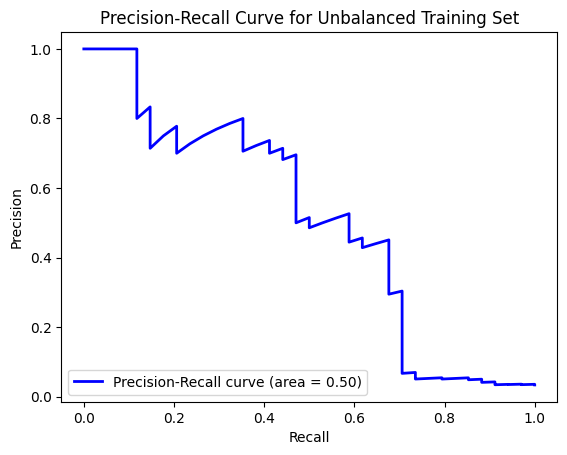

In [27]:
svm_unbalanced = SVC(C = 10, gamma = 0.001, probability=True)
svm_unbalanced.fit(X_train, y_train)

# Evaluating training accuracy
train_accuracy = accuracy_score(y_train, svm_unbalanced.predict(X_train))
print("For Unbalanced training dataset:")
print(f"rbf SVM - Training Accuracy: {train_accuracy:.2f}")

# Evaluate the best estimator on the test data
test_accuracy = svm_unbalanced.score(X_test, y_test)
print("Test Accuracy:", test_accuracy)


test_failure_accuracy = accuracy_score(y_test_failure, svm_unbalanced.predict(X_test_failure))
test_no_failure_accuracy = accuracy_score(y_test_no_failure, svm_unbalanced.predict(X_test_no_failure))

print(f"rbf SVM - Test Accuracy for failure only dataset: {test_failure_accuracy:.2f}")
print(f"rbf SVM - Test Accuracy for no failure only dataset: {test_no_failure_accuracy:.2f}")

# F1 score calucation of the model
f1 = f1_score(y_test, svm_unbalanced.predict(X_test))

# Display the F1 score
print("rbf SVM - F1 Score:", f1)
# Compute precision and recall
precision = precision_score(y_test, svm_unbalanced.predict(X_test))
recall = recall_score(y_test, svm_unbalanced.predict(X_test))
print("Precision:", precision)
print("Recall:", recall)

# Predict probabilities of class membership
y_scores = svm_unbalanced.predict_proba(X_test)[:, 1]

# Compute precision-recall curve and area under the curve (AUC)
precision, recall, _ = precision_recall_curve(y_test, y_scores)
auc_pr = auc(recall, precision)

print("AUC-PR:", auc_pr)

# Plot the precision-recall curve
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % auc_pr)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Unbalanced Training Set')
plt.legend(loc='lower left')
plt.show()

In [6]:
# For Balanced training dataset
# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [0.1, 0.01, 0.001]
}

# Create SVM classifier
svm = SVC()

# Instantiate GridSearchCV
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=9, scoring='accuracy')

# Perform grid search on the training data
grid_search.fit(X_resampled, y_resampled)

# Print the best parameters found
print("Best Parameters for balanced training data:", grid_search.best_params_)



Best Parameters for balanced training data: {'C': 10, 'gamma': 0.01}


For A Balanced training dataset:
rbf SVM - Training Accuracy: 0.99
Test Accuracy: 0.939060939060939
rbf SVM - Test Accuracy for failure only dataset: 0.44
rbf SVM - Test Accuracy for no failure only dataset: 0.96
rbf SVM - F1 Score: 0.32967032967032966
Precision: 0.2631578947368421
Recall: 0.4411764705882353
AUC-PR: 0.28561674077296206


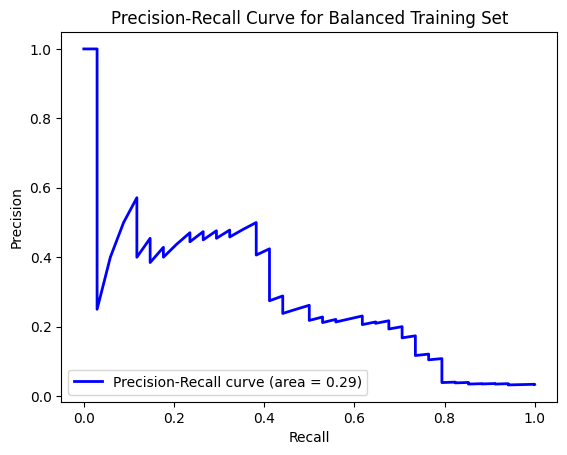

In [5]:
svm_balanced = SVC(C = 10, gamma = 0.01, probability=True)
svm_balanced.fit(X_resampled, y_resampled)

# Evaluating training accuracy
train_accuracy = accuracy_score(y_resampled, svm_balanced.predict(X_resampled))
print("For A Balanced training dataset:")
print(f"rbf SVM - Training Accuracy: {train_accuracy:.2f}")

# Evaluate the best estimator on the test data
test_accuracy = svm_balanced.score(X_test, y_test)
print("Test Accuracy:", test_accuracy)


test_failure_accuracy = accuracy_score(y_test_failure, svm_balanced.predict(X_test_failure))
test_no_failure_accuracy = accuracy_score(y_test_no_failure, svm_balanced.predict(X_test_no_failure))

print(f"rbf SVM - Test Accuracy for failure only dataset: {test_failure_accuracy:.2f}")
print(f"rbf SVM - Test Accuracy for no failure only dataset: {test_no_failure_accuracy:.2f}")

# F1 score calucation of the model
f1 = f1_score(y_test, svm_balanced.predict(X_test))

# Display the F1 score
print("rbf SVM - F1 Score:", f1)
# Compute precision and recall
precision = precision_score(y_test, svm_balanced.predict(X_test))
recall = recall_score(y_test, svm_balanced.predict(X_test))
print("Precision:", precision)
print("Recall:", recall)

# Predict probabilities of class membership
y_scores = svm_balanced.predict_proba(X_test)[:, 1]

# Compute precision-recall curve and area under the curve (AUC)
precision, recall, _ = precision_recall_curve(y_test, y_scores)
auc_pr = auc(recall, precision)

print("AUC-PR:", auc_pr)

# Plot the precision-recall curve
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % auc_pr)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Balanced Training Set')
plt.legend(loc='lower left')
plt.show()